# COP26 Analysis by Temperature Prediction using Facebook Prophet Model

## Install and Import Dependency

We first start with installing and importing dependencies required for this project

Note: PyStan required for fbprophet is already installed hence not displayed here

In [1]:
!pip install pystan fbprophet

In [2]:
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot
import datetime as dt
from datetime import date
from datetime import timedelta
from fbprophet import Prophet
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Reading Data

Now, we go ahead with reading the dataset and performing basic tasks like getting rid of outliers and processing dates

In [3]:
data0 = pd.read_csv("/Users/jaydevnani/Desktop/INFO-6105/FinalProject/city_temperature-3.csv")
data0[-5:]

,Region,Country,State,City,Month,Day,Year,AvgTemperature
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8
2906326,North America,US,Additional Territories,San Juan Puerto Rico,7,31,2013,83.6


Getting rid of outliers

In [4]:
drop=data0[data0['AvgTemperature']==-99.0].index.tolist()
data0=data0.drop(index=drop).reset_index(drop=True)

Processing Year, Month, Day column to Date

In [5]:
date=[]
for y,m,d in zip(data0['Year'],data0['Month'],data0['Day']):
    date+=[dt.datetime(y,m,d).strftime('%Y-%m-%d')]
data0['Date']=date
data0

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2,1995-01-01
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4,1995-01-02
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8,1995-01-03
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4,1995-01-04
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9,1995-01-05
...,...,...,...,...,...,...,...,...,...
2826650,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4,2013-07-27
2826651,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6,2013-07-28
2826652,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2,2013-07-29
2826653,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8,2013-07-30


In [6]:
data0.describe()

,Month,Day,Year,AvgTemperature
count,2.826655e+06,2.826655e+06,2.826655e+06,2.826655e+06
mean,6.464649e+00,1.570960e+01,2.007028e+03,6.037388e+01
std,3.455714e+00,8.800018e+00,7.268831e+00,1.909744e+01
min,1.000000e+00,1.000000e+00,1.995000e+03,-5.000000e+01
25%,3.000000e+00,8.000000e+00,2.001000e+03,4.740000e+01
50%,6.000000e+00,1.600000e+01,2.007000e+03,6.330000e+01
75%,9.000000e+00,2.300000e+01,2.013000e+03,7.590000e+01
max,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [7]:
print(data0['City'].unique().tolist())

['Algiers', 'Bujumbura', 'Cotonou', 'Bangui', 'Brazzaville', 'Cairo', 'Addis Ababa', 'Libreville', 'Banjul', 'Conakry', 'Bissau', 'Abidjan', 'Nairobi', 'Rabat', 'Antananarivo', 'Nouakchott', 'Lilongwe', 'Maputo', 'Windhoek', 'Niamey', 'Lagos', 'Dakar', 'Freetown', 'Capetown', 'Lome', 'Tunis', 'Dar Es Salaam', 'Kampala', 'Lusaka', 'Dhaka', 'Beijing', 'Chengdu', 'Guangzhou', 'Shanghai', 'Shenyang', 'Hong Kong', 'Bombay (Mumbai)', 'Calcutta', 'Chennai (Madras)', 'Delhi', 'Jakarta', 'Osaka', 'Sapporo', 'Tokyo', 'Almaty', 'Bishkek', 'Vientiane', 'Kuala Lumpur', 'Ulan-bator', 'Rangoon', 'Katmandu', 'Pyongyang', 'Islamabad', 'Karachi', 'Manila', 'Singapore', 'Seoul', 'Colombo', 'Taipei', 'Dusanbe', 'Bangkok', 'Ashabad', 'Tashkent', 'Hanoi', 'Brisbane', 'Canberra', 'Melbourne', 'Perth', 'Sydney', 'Auckland', 'Tirana', 'Vienna', 'Minsk', 'Brussels', 'Sofia', 'Zagreb', 'Nicosia', 'Prague', 'Copenhagen', 'Helsinki', 'Paris', 'Bordeaux', 'Bonn', 'Frankfurt', 'Hamburg', 'Munich', 'Tbilisi', 'Athens

In [25]:
print(data0['City'].nunique())

321


As can be seen here, our dataset contains 321 unique cities!! For a more specific and simpler understanding, we have taken 5 cities

In [8]:
cities=['Tokyo','New York City','London', 'Bombay (Mumbai)', 'Beijing']

All functions can and will be performed to all cities taken in the list, but we will focus on Tokyo for now to show the steps, but eventually will see all the cities mentioned above in the list

In [9]:
data1=data0[data0['City']=='Tokyo']

All other data now is unnecessary and we only really need the date and avg temperature columns

In [10]:
data2=data1[['Date','AvgTemperature']].reset_index(drop=True)
data2

,Date,AvgTemperature
0,1995-01-01,43.0
1,1995-01-02,40.8
2,1995-01-03,43.3
3,1995-01-04,44.9
4,1995-01-05,47.6
...,...,...
9232,2020-05-09,67.1
9233,2020-05-10,71.1
9234,2020-05-11,70.9
9235,2020-05-12,71.5


## Visualizing and Prophet-ing Data

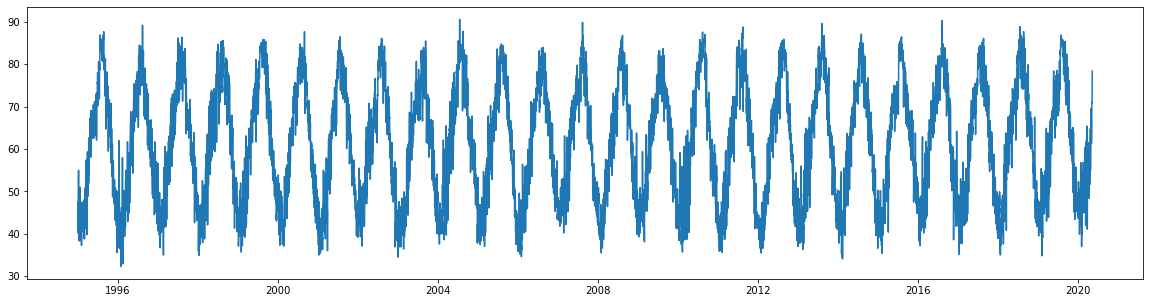

In [11]:
item1=data2

item1.columns = ['ds','y']
item1.y = item1.y.astype('float')
item1.ds = item1.ds.astype('datetime64')

rcParams['figure.figsize'] = 20,5
plt.plot(item1.ds, item1.y)

Training the data using Facebook Prophet Model and predicting it using past data

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


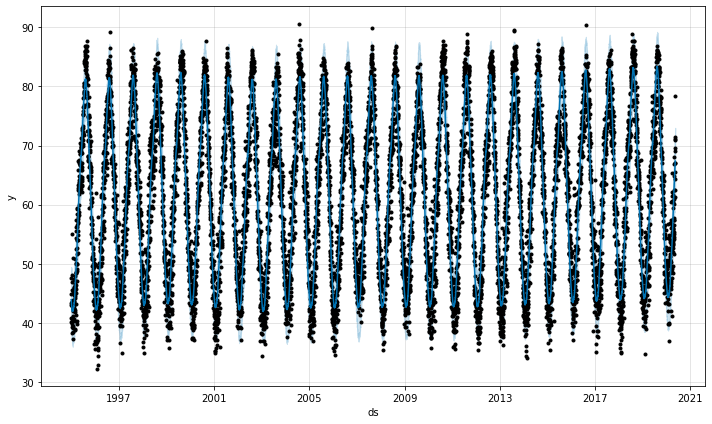

In [12]:
ph = Prophet()
ph.fit(item1)
forecast1=ph.predict(item1)
figure = ph.plot(forecast1)
figure.show()

## Future Predictions

Here we predict the temperature for future dates from past data

The dataset has dates upto May 13, 2020, hence I have started the prediction from May 14, 2020

In [18]:
from datetime import timedelta
start0 = dt.datetime.strptime('2020-05-14','%Y-%m-%d').date()
end0   = dt.datetime.strptime('2025-12-31','%Y-%m-%d').date()
print((end0-start0).days)

2057


In [19]:
def daterange(start,end):
    for i in range((end-start).days):
        return start+timedelta(i)  

In [20]:
dates0=[]
for i in range((end0-start0).days):
    dates0+=[(start0+timedelta(i)).strftime('%Y-%m-%d') ]
print(dates0[0:10])

['2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-23']


In [21]:
dates0_df=pd.DataFrame(dates0)
dates0_df.columns=['ds']
dates0_df

,ds
0,2020-05-14
1,2020-05-15
2,2020-05-16
3,2020-05-17
4,2020-05-18
...,...
2052,2025-12-26
2053,2025-12-27
2054,2025-12-28
2055,2025-12-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


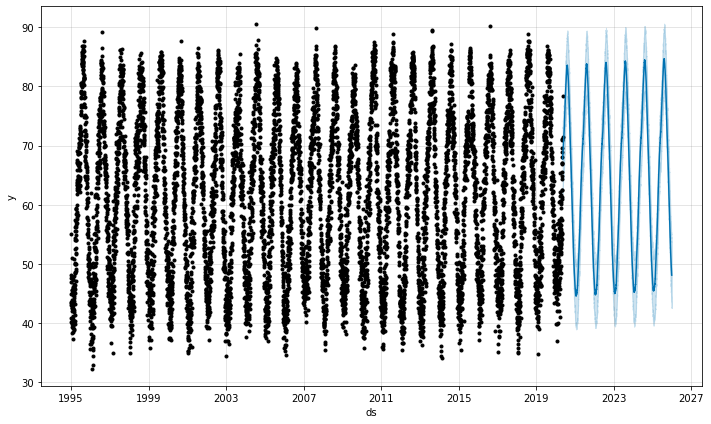

In [22]:
ph = Prophet()
ph.fit(item1)
forecast3=ph.predict(dates0_df)
figure = ph.plot(forecast3)
figure.show()

Our prophet model has successfully predicted the temperatures of almost the next 5 years! While this is great news in terms of data science, the prediction is bad for the environment in the future. This shows a steady incline in the increasing years of the temperature which is possibly because of Global Warming.

We now use this model on all other cities in the list, which is done below.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


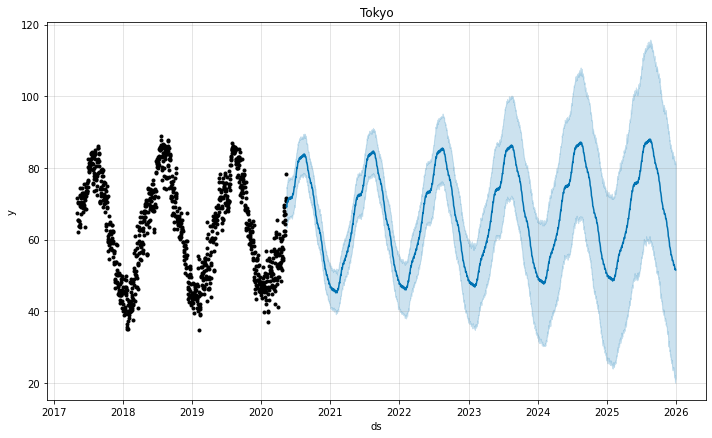

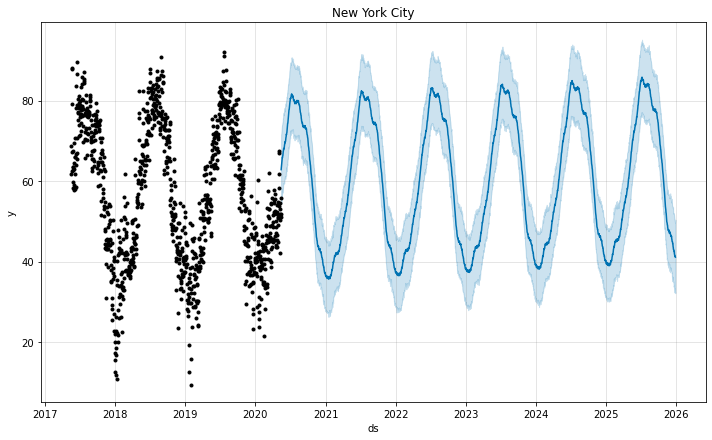

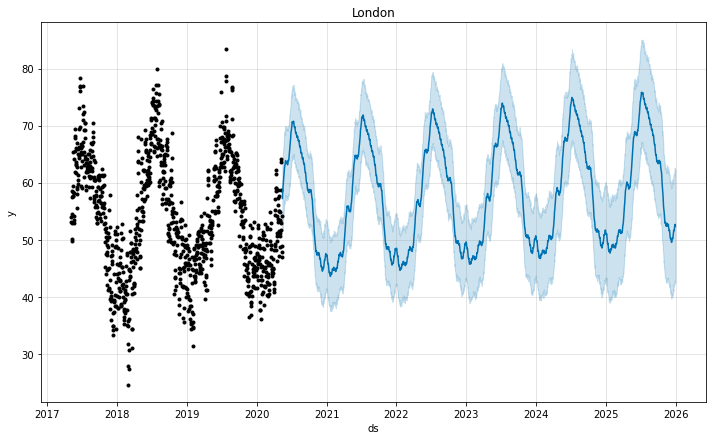

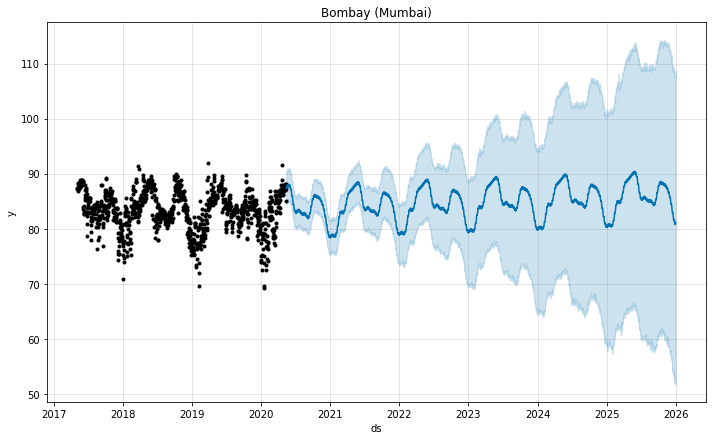

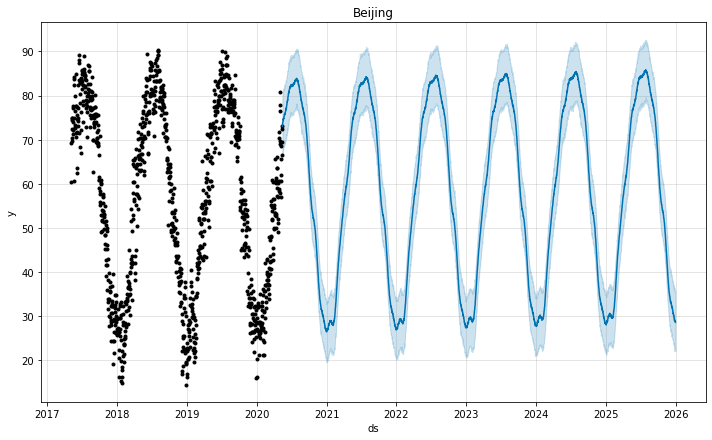

In [23]:
for item in cities:
    data1=data0[data0['City']==item]
    #data1['date']=pd.to_datetime(data1['date'])
    item1=data1[['Date','AvgTemperature']]

    item1.columns = ['ds','y']
    item1.y = item1.y.astype('float')
    item1.ds = item1.ds.astype('datetime64')

    ph = Prophet()
    ph.fit(item1[-365*3:])
    forecast3=ph.predict(dates0_df)
    figure = ph.plot(forecast3)
    plt.title(item)
    figure.show()

Again, rising temperatures can be seen and is something we should definitely be worried about